In [1]:
%cd ..
%pwd
# %cd code
# should be /code
# 
%load_ext autoreload
%autoreload 2

/home/oli/Research/Joe/agent-goals/code


In [2]:
from pgmpy.models import BayesianNetwork,  FactorGraph

from pgmpy.readwrite import BIFReader
# reader = BIFReader('data/alarm.bif')
reader = BIFReader('data/asia.bif')
#reader.get_edges()
alarm = reader.get_model()

In [3]:
from pdg import PDG
from pdg.rv import Variable as Var
from pdg.dist import CPT, RawJointDist as RJD
from pdg.alg import interior_pt as ip

import numpy as np
import cvxpy as cp
import dccp

## Tests for `ip.cvx_opt_*` 

In [6]:
alarm_PDG = PDG.from_BN(alarm)

In [5]:
# VERY DANGEROUS!!
#ip.cvx_opt_clusters(alarm_PDG)
#

Cs = list(alarm_PDG.to_markov_net().to_junction_tree().nodes())
print(list(Cs))
print(sorted([len(c) for c in Cs], reverse=True))


import numpy as np
print([np.prod([len(alarm_PDG.vars[X]) for X in C]) for C in Cs])

# prob = ip.cvx_opt_clusters(alarm_PDG, Cs, also_idef=False, dry_run=True, verbose=True)

# print(ns, sum(ns))

[('smoke', 'either', 'bronc'), ('smoke', 'either', 'xray', 'lung', 'tub'), ('dysp', 'either', 'bronc'), ('smoke', 'asia', 'lung', 'xray', 'tub')]
[5, 5, 3, 3]
[8, 32, 8, 32]


In [6]:
smoke,lung,bronc = alarm_PDG.vars['smoke'], alarm_PDG.vars['lung'], alarm_PDG.vars['bronc']
dysp,either = alarm_PDG.vars['dysp'], alarm_PDG.vars['either']

alarm_PDG.factor_product()[smoke,lung,bronc]

,"((yes, yes), yes)","((yes, yes), no)","((yes, no), yes)","((yes, no), no)","((no, yes), yes)","((no, yes), no)","((no, no), yes)","((no, no), no)"
⋆,0.03,0.02,0.27,0.18,0.0015,0.0035,0.1485,0.3465


In [35]:
full_F = ip.cvx_opt_clusters(alarm_PDG, varname_clusters=[[V.name for V in alarm_PDG.varlist]], 
    also_idef=False,verbose=True).marginals[0]
# full_F[smoke, lung, bronc]
full_T = ip.cvx_opt_clusters(alarm_PDG, varname_clusters=[[V.name for V in alarm_PDG.varlist]],
     also_idef=True, verbose=True).marginals[0]


marginalsF = ip.cvx_opt_clusters(alarm_PDG, also_idef=False, verbose=True).marginals
marginalsT = ip.cvx_opt_clusters(alarm_PDG, also_idef=True, verbose=True).marginals

joint_F = ip.cvx_opt_joint(alarm_PDG, also_idef=False, verbose=True)
joint_T = ip.cvx_opt_joint(alarm_PDG, also_idef=True, verbose=True)

Finding Elimination Order: : 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]
Finding Elimination Order: : : 0it [00:10, ?it/s]

[(0, ('asia', 'smoke', 'bronc', 'either', 'dysp', 'lung', 'tub', 'xray'))]
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Sep 12 02:55:41 PM: Your problem has 292 variables, 10 constraints, and 0 parameters.
(CVXPY) Sep 12 02:55:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 12 02:55:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 12 02:55:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 12 02:55:41 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Sep 12 02:

(CVXPY) Sep 12 02:55:41 PM: Finished problem compilation (took 1.774e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 12 02:55:41 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Sep 12 02:55:41 PM: Problem
(CVXPY) Sep 12 02:55:41 PM:   Name                   :                 
(CVXPY) Sep 12 02:55:41 PM:   Objective sense        : max             
(CVXPY) Sep 12 02:55:41 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Sep 12 02:55:41 PM:   Constraints            : 292             
(CVXPY) Sep 12 02:55:41 PM:   Cones                  : 36              
(CVXPY) Sep 12 02:55:41 PM:   Scalar variables       : 365             
(CVXPY) Sep 12 02:55:41 PM:   Matrix variables       : 0               
(CVXPY) Sep 12 02:55:41 PM:   Integer variab

In [96]:
full_T[smoke,lung,bronc]

,"((yes, yes), yes)","((yes, yes), no)","((yes, no), yes)","((yes, no), no)","((no, yes), yes)","((no, yes), no)","((no, no), yes)","((no, no), no)"
⋆,0.03,0.02,0.27,0.18,0.0015,0.0035,0.1485,0.3465


In [33]:
from pgmpy.inference.ExactInference import BeliefPropagation, VariableElimination

bp = BeliefPropagation(alarm)
ve = VariableElimination(alarm)

bp2 = BeliefPropagation(alarm.to_markov_model())
ve2 = BeliefPropagation(alarm.to_markov_model())

bp.calibrate()
bp2.calibrate()

# takes 48 seconds;
# ... or 1m 2sec
# takes 5GB RAM. 

In [143]:
bp.get_cliques()

NodeView((('dysp', 'bronc', 'either'), ('xray', 'tub', 'lung', 'bronc', 'either'), ('xray', 'tub', 'lung', 'bronc', 'smoke'), ('xray', 'tub', 'asia', 'smoke')))

In [26]:
[f.values.size for f in bp.get_clique_beliefs().values()]

[8, 32, 32, 16]

In [215]:
fg = alarm_PDG.to_FG(drop_joints=True)
mm = alarm.to_markov_model()
print("Same factors...")
print(' > ',[f.scope() for f in mm.factors], ';')
print(' > ',[fg.scope(f) for f in fg.factors])
print()

for (discf, f) in zip(mm.factors, fg.factors):
    assert set(discf.scope()) == set(fg.scope(f))
    
    

Same factors...
 >  [['asia'], ['bronc', 'smoke'], ['dysp', 'bronc', 'either'], ['either', 'lung', 'tub'], ['lung', 'smoke'], ['smoke'], ['tub', 'asia'], ['xray', 'either']] ;
 >  [['asia'], ['smoke', 'bronc'], ['bronc', 'either', 'dysp'], ['either', 'lung', 'tub'], ['smoke', 'lung'], ['smoke'], ['asia', 'tub'], ['either', 'xray']]



In [256]:
tcpd = alarm.get_cpds("dysp")
# print(tcpd.get_evidence())
# print(tcpd.values[0,1])
# tcpd.store_state_names(['bronc','either'],[2,2], {'bronc' : ['+','-'], 'either':['y', 'n']})
print(tcpd)
print(tcpd.variables[:0])
print(tcpd.values[0][0,1])


p = CPT.from_pgmpy(tcpd)
print(p.nfrom)
p

# alarm_PDG[ alarm_PDG.vars['dysp'] | alarm_PDG.vars['either'] & alarm_PDG.vars['bronc'] ]

+-----------+-------------+------------+-------------+------------+
| bronc     | bronc(yes)  | bronc(yes) | bronc(no)   | bronc(no)  |
+-----------+-------------+------------+-------------+------------+
| either    | either(yes) | either(no) | either(yes) | either(no) |
+-----------+-------------+------------+-------------+------------+
| dysp(yes) | 0.9         | 0.8        | 0.7         | 0.1        |
+-----------+-------------+------------+-------------+------------+
| dysp(no)  | 0.1         | 0.2        | 0.3         | 0.9        |
+-----------+-------------+------------+-------------+------------+
[]
0.8
Var either×bronc {('yes', 'yes'), ('yes', 'no'), ('no', 'yes'), ('no', 'no')}


,yes,no
"(yes, yes)",0.9,0.1
"(yes, no)",0.8,0.2
"(no, yes)",0.7,0.3
"(no, no)",0.1,0.9


In [32]:


vevars = [alarm_PDG.vars[n] for n in ve.variables]

# ve_vals = ve.query([V.name for V in reversed(alarm_PDG.varlist)]).values
Q = ve.query(ve.variables)
ve_vals = Q.values
# print(ve.)

ve_rjd_1 = RJD(ve_vals, vevars)
ve_rjd_2 = RJD(ve_vals, alarm_PDG.varlist)
ve_rjd_3 = RJD(ve_vals, list(reversed(vevars)))
ve_rjd = RJD(ve_vals, [alarm_PDG.vars[n] for n in Q.variables])


print(ve.query(['asia']))

print('[1]      vevars:',[V.name for V in ve_rjd_1.varlist])
print('[2] pdg varlist:',[V.name for V in ve_rjd_2.varlist])
print('[3]  ve reversed:',[V.name for V in ve_rjd_3.varlist])
print('[4]  query order:',[V.name for V in ve_rjd.varlist])


print(ve_rjd_1[alarm_PDG.vars['asia']].to_numpy())
print(ve_rjd_2[alarm_PDG.vars['asia']].to_numpy())
print(ve_rjd_3[alarm_PDG.vars['asia']].to_numpy())
print(ve_rjd[alarm_PDG.vars['asia']].to_numpy())


# jointT[alarm_PDG.vars['smoke']]

0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+-------------+
| asia      |   phi(asia) |
+===========+=============+
| asia(yes) |      0.0100 |
+-----------+-------------+
| asia(no)  |      0.9900 |
+-----------+-------------+
[1]      vevars: ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
[2] pdg varlist: ['asia', 'smoke', 'bronc', 'either', 'dysp', 'lung', 'tub', 'xray']
[3]  ve reversed: ['dysp', 'xray', 'either', 'bronc', 'lung', 'smoke', 'tub', 'asia']
[4]  query order: ['bronc', 'smoke', 'either', 'xray', 'asia', 'dysp', 'lung', 'tub']
[[0.45 0.55]]
[[0.45 0.55]]
[[0.01 0.99]]
[[0.01 0.99]]


In [36]:
np.set_printoptions(precision=3)

def toVars(*varnames):
    return [alarm_PDG.vars[v] for v in varnames]

VVn = ('dysp', 'bronc', 'either')
# VVn = ('dysp',)
# VVn = ('either', 'bronc')


VV = toVars(*VVn)
clique = next(c for c in bp.get_cliques() if all(v in c for v in VVn))

bp_cluster_rjd = RJD(bp.get_clique_beliefs()[clique].values, [alarm_PDG.vars[n] for n in clique])
bp2_cluster_rjd = RJD(bp2.get_clique_beliefs()[clique].values, [alarm_PDG.vars[n] for n in clique])

print('BP\t\t', bp_cluster_rjd[VV].to_numpy().reshape(-1))
print('BP2\t\t',  bp2_cluster_rjd[VV].to_numpy().reshape(-1))
print('var elim\t', ve.query(list(VVn)).values.reshape(-1))
Q = ve.query(ve.variables)
ve_rjd = RJD(Q.values, [alarm_PDG.vars[n] for n in Q.variables] )
# print(vals.shape, vals.sum())
print('var elim2\t', ve_rjd[VV].to_numpy().reshape(-1))
print()


cluster_idx = next(i for (i,m) in enumerate(marginalsF) if all(v in m.varlist for v in VV))

print('cvx-cluster-F\t', marginalsF[cluster_idx][VV].to_numpy().reshape(-1))
print('cvx-big-clust-F\t', full_F[VV].to_numpy().reshape(-1))
print('cvx-joint-F\t', joint_F[VV].to_numpy().reshape(-1))
print('cvx-cluster-T\t',marginalsT[cluster_idx][VV].to_numpy().reshape(-1))
print('cvx-big-clust-T\t', full_T[VV].to_numpy().reshape(-1))
print('cvx-joint-T\t', joint_T[VV].to_numpy().reshape(-1))
print()


print('factor-product\t', alarm_PDG.factor_product()[VV].to_numpy().reshape(-1))
print('factor-graph\t', alarm_PDG.to_FG().dist[VV].to_numpy().reshape(-1))
# print('fg (dropjoint)\t', fg.dist[VV].to_numpy().reshape(-1))
print('fg (dropjoint)\t', alarm_PDG.to_FG(drop_joints=True).dist[VV].to_numpy().reshape(-1))





Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 143.51it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]

BP		 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
BP2		 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
var elim	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
var elim2	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]

cvx-cluster-F	 [0.028 0.335 0.021 0.052 0.003 0.084 0.009 0.468]
cvx-big-clust-F	 [0.033 0.331 0.018 0.052 0.004 0.083 0.008 0.472]
cvx-joint-F	 [0.033 0.331 0.018 0.052 0.004 0.083 0.008 0.472]
cvx-cluster-T	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
cvx-big-clust-T	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
cvx-joint-T	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]

factor-product	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
factor-graph	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
fg (dropjoint)	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]


## Tests for the CCCP for when $\gamma > 0$.

In [116]:
np.set_printoptions(precision=3)

gamma1 = ip.cccp_opt_joint(alarm_PDG, 0, max_iters=40)

print('fg (dropjoint)\t', alarm_PDG.to_FG(drop_joints=True).dist[VV].to_numpy().reshape(-1))
print('gamma=1 \t', gamma1[VV].to_numpy().reshape(-1))

(cave)   p9 	 -9
(cave)   p10 	 -9
(cave)   p11 	 -9
(cave)   p12 	 -9
(cave)   p13 	 -9
(cave)   p14 	 -9
(cave)   p15 	 -9
(cave)   p16 	 -9
-39.03173965920813


/home/oli/Research/Joe/agent-goals/code/pdg/alg/interior_pt.py:518: RuntimeWarning: divide by zero encountered in log
  )


-39.644502165044514
-38.884747967732
-37.35627681702235
-35.529073666468335
-33.690325297657004
-31.98304651789694
-30.461326973503073
-29.132875770192314
-27.98465194128337
-26.996080660670547
-26.145413278202916
-25.41238544445865
-24.779160770914693
-24.230652240936628
-23.754091648275153
-23.338762072846805
-22.97581856780329
-22.657717343344274
-22.37827980792716
-22.132184061798235
-21.915038659528122
-21.72308572053473
-21.553058499440226
-21.40223031432614
-21.268225778403206
-21.14899532977421
-21.042872056161826
-20.948292605469323
-20.863802996962473
-20.78835220093672
-20.721140499616467
-20.6608083393088
-20.606802563975652
-20.558455587614382
-20.515149122397144
-20.4763630781285
-20.44220760738485
-20.41094013568982
-20.382853925699514
fg (dropjoint)	 [0.032 0.331 0.02  0.052 0.004 0.083 0.009 0.469]
gamma=1 	 [0.033 0.33  0.021 0.053 0.004 0.084 0.009 0.465]


In [112]:
print("Inc: ", alarm_PDG.Inc(gamma1), "\tIDef: ", alarm_PDG.IDef(gamma1))
# alarm_PDG[alarm_PDG.vars['either'] | alarm_PDG.vars['lung'] & alarm_PDG.vars['tub']]

Inc:  (2.0165899730399794+0j) 	IDef:  0.0007020721559780618


In [100]:
gamma1[alarm_PDG.vars['either'] | alarm_PDG.vars['lung'],alarm_PDG.vars['tub']]


,yes,no
"(yes, yes)",1.0,0.0
"(yes, no)",1.0,0.0
"(no, yes)",1.0,0.0
"(no, no)",0.0,1.0


In [7]:
import cvxpy as cp
# cp.installed_solvers()
print(np.prod(alarm_PDG.dshape))

# ip._cvx_opt_direct(alarm_PDG, 1E-12)


256


/home/oli/.local/lib/python3.8/site-packages/pgmpy/models/MarkovNetwork.py:448: RuntimeWarning: invalid value encountered in long_scalars
  S_by_C = {key: S[key] / C[key] for key in S}


ValueError: No CPD associated with tub

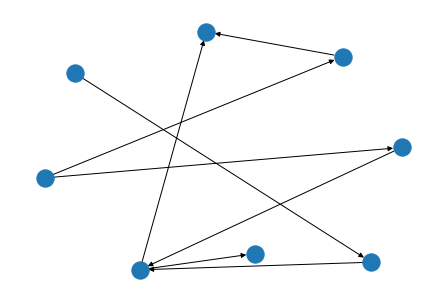

In [25]:
mm = alarm.to_markov_model()
bn2 = mm.to_bayesian_model()

import networkx as nx
nx.draw(alarm)

bn2.check_model()